# BLUESKY Demo for ALS Controls

## Summary
This notebook will demonstrate how to:
1. Connect to and directly manipulate ALS devices with Ophyd objects
2. Scan ALS devices with Bluesky "plans"
3. Compose a customized plan using feedback from data analysis to drive acquisition

## Controlling ALS devices directly
First, lets initialize the notebook, importing required packages and setting initial configuration

# BLUESKY Demo for ALS Controls

## Summary
This notebook will demonstrate how to:
1. Connect to and directly manipulate ALS devices with Ophyd objects
2. Scan ALS devices with Bluesky "plans"
3. Compose a customized plan using feedback from data analysis to drive acquisition

## Controlling ALS devices directly
First, lets initialize the notebook, importing required packages and setting initial configuration

In [3]:
%matplotlib notebook

# Set environment variables. The control layer for Ophyd must be set to use Caproto for ALS devices
import os
os.environ['OPHYD_CONTROL_LAYER'] = 'caproto'

# Import Bluesky and Ophyd components
import ophyd
from bluesky import RunEngine
from bluesky.plans import scan, rel_scan, list_scan, grid_scan, count
from bluesky.callbacks import LivePlot, LiveTable, LiveFitPlot, LiveFit, LiveGrid
import bluesky.preprocessors as bpp
import bluesky.plan_stubs as bps

# Import special Ophyd classes for ALS hardware
from alsdac.ophyd import Instrument, ScalarInstrument, Motor

# Configure plots to update live while scans run.
from bluesky.utils import install_kicker
install_kicker()

# Import mathematics packages
import lmfit
import numpy as np
from scipy import ndimage

# Import plotting tools
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from matplotlib import colors

# Import standard libraries
import time

# Initialize the Bluesky Run Engine
RE = RunEngine({})

Lets create Ophyd objects for some of the devices:

In [4]:
x = Motor('beamline:motors:esp300axis2', name='x', settle_time=.1)  # X Motor
z = Motor('beamline:motors:esp300axis3', name='z', settle_time=.1)  # Z Motor
cam = Instrument('beamline:instruments:ptGreyInstrument', name='cam')  # Area detector camera
scalarcam = ScalarInstrument('beamline:instruments:ptGreyInstrument', name='scalarcam') # Scalar detector

We can get and set values to these devices:

In [5]:
x.position  # Last read position (currently limited use without callbacks from LabView)

-2.71378

In [4]:
x.user_readback.get(use_monitor=False)  # Read the position

-2.71378

In [6]:
status = x.set(-2.)  # Move the X Motor
ophyd.status.wait(status)  # Wait until the move completes
print(status)  # Show that the move is finished and successful

MoveStatus(done=True, pos=x, elapsed=4.9, success=True, settle_time=0.1)


In [19]:
x.get()

MotorTuple(user_readback=1.99994, user_setpoint=2.0, user_offset=0.0, user_offset_dir=0.0, offset_freeze_switch=0.0, set_use_switch=0.0, velocity=0.0, acceleration=0.0, motor_egu='units', motor_is_moving=0, motor_done_move=0.0, high_limit_switch=0.0, low_limit_switch=0.0, direction_of_travel=0.0, motor_stop=0.0, home_forward=0.0, home_reverse=0.0)

<IPython.core.display.Javascript object>


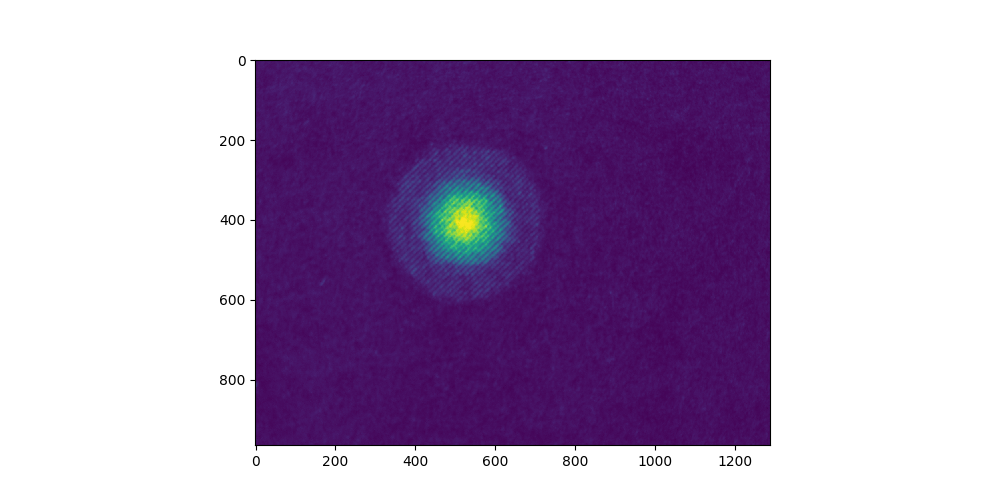

In [7]:
cam.trigger()  # Trigger the area detector
data = cam.read()['cam_image']['value']  # Read the acquired image
plt.imshow(data, interpolation='nearest')

In [13]:
x.set(-4)
z.set(-.6)

MoveStatus(done=False, pos=z, elapsed=0.1, success=False, settle_time=0.1)

You *could* try automating a coordinated movement or acquisition of multiple devices, but let Bluesky do this for you!

## Using Bluesky "plans" for automation

Suggested reading, introduction to Bluesky: http://try.nsls2.bnl.gov/?urlpath=notebooks/tutorials/Hello%20Bluesky.ipynb

"Plans" are scripted, coordinated actions spanning multiple devices. Here are some simple examples using the builtin `scan` plan.

In [18]:
RE(scan([scalarcam], x, -5, -3, 10), LiveTable([scalarcam.image, x]))  # A scan of the scalar detector moving in x

+-----------+------------+-----------------+------------+-----------------+
|   seq_num |       time | scalarcam_image |          x | x_user_setpoint |
+-----------+------------+-----------------+------------+-----------------+
|         1 | 17:14:50.1 |          127232 |     -5.000 |          -5.000 |
|         2 | 17:14:54.0 |          638944 |     -4.778 |          -4.778 |
|         3 | 17:14:58.1 |          748480 |     -4.556 |          -4.556 |
|         4 | 17:15:02.1 |          851312 |     -4.333 |          -4.333 |
|         5 | 17:15:06.1 |          851312 |     -4.111 |          -4.111 |
|         6 | 17:15:10.1 |          849392 |     -3.889 |          -3.889 |
|         7 | 17:15:14.0 |          715184 |     -3.667 |          -3.667 |
|         8 | 17:15:18.0 |          597616 |     -3.444 |          -3.444 |
|         9 | 17:15:22.0 |          457440 |     -3.222 |          -3.222 |
|        10 | 17:15:26.0 |          376992 |     -3.000 |          -3.000 |
+-----------

('dea47c79-f522-4eaf-9ef3-14164f97c885',)

<IPython.core.display.Javascript object>


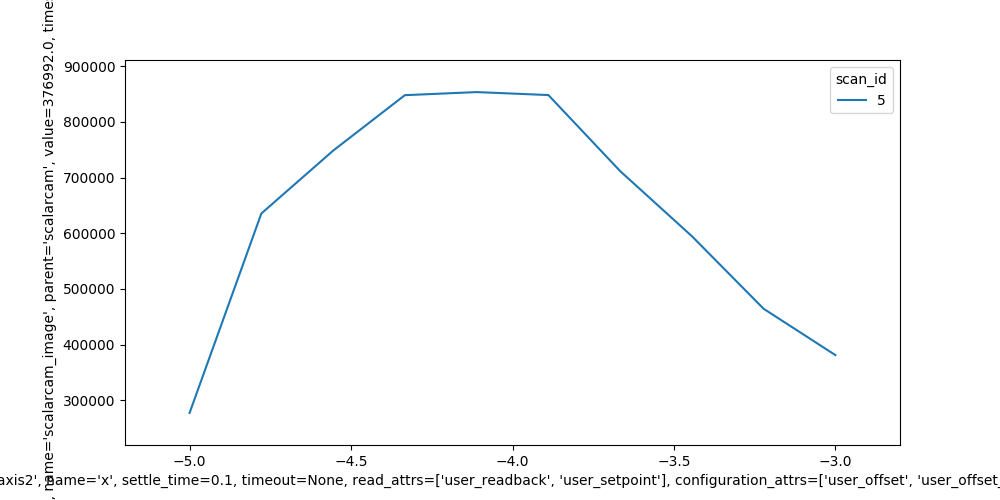

('173d4e4a-2ab8-44aa-8d8c-4319db18abc7',)

In [19]:
RE(scan([scalarcam], x, -5, -3, 10), LivePlot(scalarcam.image, x))  # The same scan, displayed as a plot

<IPython.core.display.Javascript object>


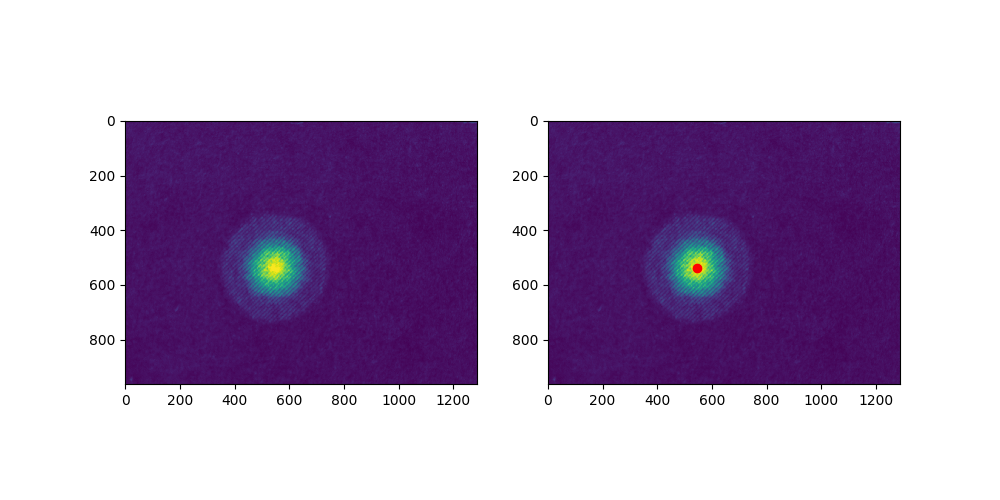

('519e4331-c502-4843-b137-f15025ebcdc5',)

In [23]:
RE(grid_scan([scalarcam], x, -5, -3, 10, z, -2, 0, 10, False), LiveGrid((10, 10), scalarcam.image.name))

You can apply also live fits to scans, and extract parameters:

<IPython.core.display.Javascript object>


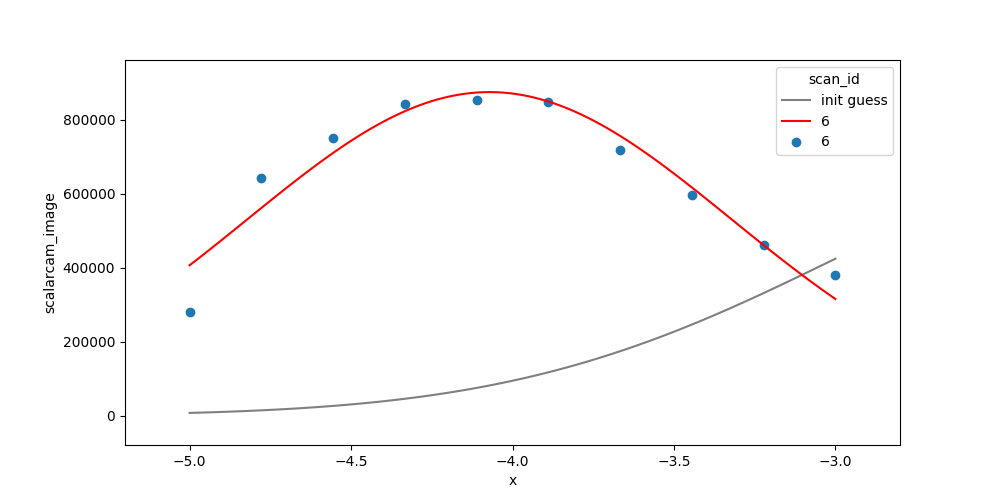

Mean: <Parameter 'x0', value=-4.071390496191387 +/- 0.0379, bounds=[-inf:inf]>


In [20]:
def gaussian(x, A, sigma, x0):
    return A*np.exp(-(x - x0)**2/(2 * sigma**2))

model = lmfit.Model(gaussian)
init_guess = {'A': 700000,
              'sigma': lmfit.Parameter('sigma',1, min=0),
              'x0': -2.}

fig, ax = plt.subplots()
lf = LiveFit(model, 'scalarcam_image', {'x': 'x'}, init_guess)
lpf = LiveFitPlot(lf, color='r', ax=ax)
lp = LivePlot('scalarcam_image', 'x', ax=ax, marker='o', linestyle='none')
RE(scan([scalarcam], x, -5, -3, 10), [lpf,lp])
print('Mean:', lf.result.params['x0'])

[WIP] You can also compose multiple scans into a single plan. This custom plan will scan/fit/optimize x, then z, then x again, aligning the detector to the beam center.

In [22]:
def gaussian(x, A, sigma, x0):
    return A*np.exp(-(x - x0)**2/(2 * sigma**2))

model = lmfit.Model(gaussian)
init_guess = {'A': 700000,
              'sigma': lmfit.Parameter('sigma',1, min=0),
              'x0': -2.}

lf = LiveFit(model, 'scalarcam_image', {'x': 'scan_axis'}, init_guess)

motor = x.user_readback.name
def align_plan(md=None, steps=10):
    if md is None: md = {}
    @bpp.subs_decorator([lf])
    def align():
        # Scan X
        x.user_readback.name = "scan_axis"
        yield from scan([scalarcam], x, -5, -3, steps, md=md)
        mean = lf.result.params['x0'].value
        if mean<-5 or mean>-3:
            raise ValueError
        print('Aligned to x = ', mean)
        yield from bps.mov(x, mean)
        x.user_readback.name = "x"
        
        # Scan Z
        z.user_readback.name = "scan_axis"
        yield from scan([scalarcam], z, -2, 0, steps, md=md)
        mean = lf.result.params['x0'].value
        if mean>0 or mean<-2:
            raise ValueError
        yield from bps.mov(z, mean)
        print('Aligned to z = ', mean)
        z.user_readback.name = "z"
        
        # Rescan X
        x.user_readback.name = "scan_axis"
        yield from scan([scalarcam], x, -5, -3, steps, md=md)
        mean = lf.result.params['x0'].value
        if mean<-5 or mean>-3:
            raise ValueError
        yield from bps.mov(x, mean)
        print('Aligned to x = ', mean)
        x.user_readback.name = "x"
        
    yield from align()
RE(align_plan(steps=10), LiveTable([scalarcam.image.name]))

+-----------+------------+-----------------+
|   seq_num |       time | scalarcam_image |
+-----------+------------+-----------------+
|         1 | 17:19:45.1 |          281536 |
|         2 | 17:19:49.0 |          641648 |
|         3 | 17:19:53.0 |          744048 |
|         4 | 17:19:56.9 |          840688 |
|         5 | 17:20:00.9 |          854816 |
|         6 | 17:20:05.0 |          851600 |
|         7 | 17:20:09.0 |          721776 |
|         8 | 17:20:13.1 |          592112 |
|         9 | 17:20:17.0 |          464432 |
|        10 | 17:20:21.0 |          381344 |
+-----------+------------+-----------------+
generator scan ['dd2c1a89'] (scan num: 8)
Aligned to x =  -4.068858562785602
+-----------+------------+-----------------+
|   seq_num |       time | scalarcam_image |
+-----------+------------+-----------------+
|         1 | 17:20:38.2 |          282400 |
|         2 | 17:20:44.1 |          320640 |
|         3 | 17:20:49.1 |          425824 |
|         4 | 17:20:55.

('dd2c1a89-06d7-46e1-b57a-dadd3ce0f8a0',
 '396b23cf-4d54-4b72-95c9-5ead9585ab07',
 '3f39c79e-0f5f-402a-a7b5-7e446df21852')

We can interrupt the kernel to stop a scan, and then either abort or resume the scan:

In [6]:
RE.abort()

Aborting: running cleanup and marking exit_status as 'abort'...


['0b81d5aa-cd55-4c6f-8a51-09435210a8fa',
 'da5e1371-eaf2-4e6c-9a6c-88934cfbb3de']

## Connecting Controls/Acquisition and Data Analysis

### Example 1: Inline AgB Calibration

/home/rp/.conda/envs/bluesky/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
  File "<ipython-input-10-a30389eeff82>", line 72, in calibrate_agb
    calibrant1stpeak = calibrant.ALL_CALIBRANTS['AgBh'].dSpacing[N-1]
  File "<ipython-input-10-a30389eeff82>", line 89, in <module>
    calibrant = calibrant.ALL_CALIBRANTS['AgBh']


<IPython.core.display.Javascript object>


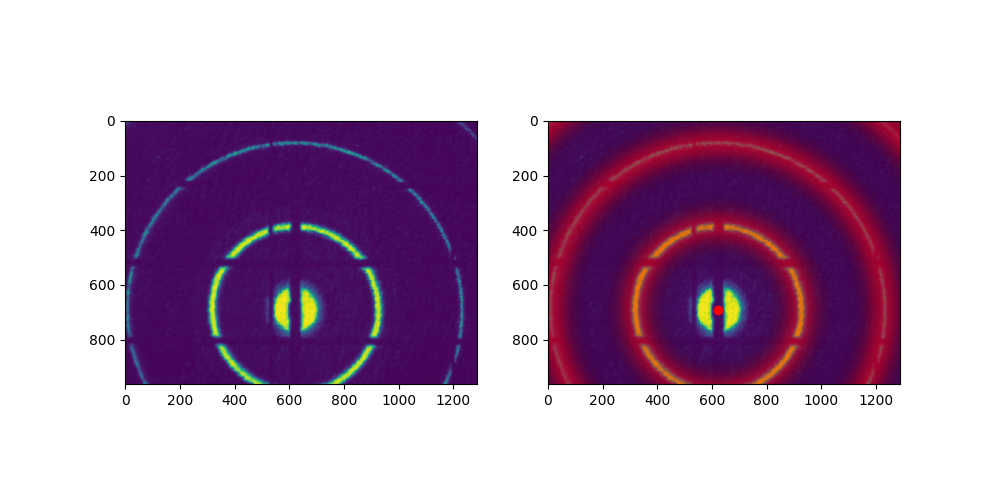

In [10]:
from scipy import optimize
from scipy import signal
from pyFAI import calibrant, geometry, detectors

wavelet = signal.ricker # wavelet of choice
widths = np.arange(1, 20) # range of widths of the ricker wavelet to search/evaluate
max_distances = widths / 8. # ridgeline connectivity threshold; smaller values gives more peaks; larger values considers overlapping peaks as one
gap_thresh = 4 # threshold number of rows for ridgeline connectivity; smaller values gives more peaks
min_length = 3 # minimum ridgeline length; smaller values gives more peaks
min_snr = 2 # Minimum SNR
noise_perc = 10 # percentile of points below which to consider noise
h = 3 # number of points skipped in finite differences
truncationlow = 10 # low q truncation for zeros
truncationhigh = 50 # high q truncation for zeros

wavelength = 124.e-12
pixelsize = 172.e-6


def findpeaks(x, y):
    peaks = signal.find_peaks_cwt(y,widths,wavelet,max_distances,gap_thresh,min_length,min_snr,noise_perc)
    peaks = peaks[1:]
    return list(np.array(np.vstack([x[peaks.astype(int)],y[peaks.astype(int)],peaks])))


def pixel_2Dintegrate(data, center, mask=None):

    # mask data
    data = data * mask

    # calculate data radial profile
    x, y = np.indices(data.shape)
    r = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel(), (mask).ravel())
    radialprofile = tbin / nr

    return radialprofile

def center_approx(img, mask):
    
    con = signal.fftconvolve(img.astype(int)*mask*(img>0), img.astype(int)*mask*(img>0)) / np.sqrt(signal.fftconvolve(np.ones_like(img), np.ones_like(img)))

    cen = np.array(np.unravel_index(con.argmax(), con.shape)) / 2.
    return cen

def calibrate_agb(data, wavelength=wavelength, pixelsize=pixelsize, mask=None):
    if mask is None: mask = np.ones_like(data)
        
    center = center_approx(data, mask)

    radialprofile = pixel_2Dintegrate(data, center, mask=mask)

    peaks = np.array(findpeaks(np.arange(len(radialprofile)), radialprofile)).T

    peaks = peaks[peaks[:, 1].argsort()[::-1]]
    
    for peak in peaks:
        if peak[0] > 15 and not np.isinf(peak[1]):  ####This thresholds the minimum sdd which is acceptable
            bestpeak = peak[0]
            # print peak
            break

    N = 1
    # guess which order is the first
    stds=[np.std((peaks[:,0]/(np.arange(len(peaks))+i))[:4]) for i in range(1,5)]
    if min(stds)<5: # threshold accepting peak as higher N
        N=np.argmin(stds)+1 # index of the first detected peak

    calibrant1stpeak = calibrant.ALL_CALIBRANTS['AgBh'].dSpacing[N-1]

    # Calculate sample to detector distance for lowest q peak
    tth = 2 * np.arcsin(0.5 * wavelength / calibrant1stpeak / 1.e-10)
    tantth = np.tan(tth)
    sdd = bestpeak * pixelsize / tantth

    return center, sdd


cam.trigger()
data = cam.read()['cam_image']['value']
center, sdd = calibrate_agb(data)

ai = geometry.Geometry()
ai.detector = detectors.Detector(max_shape=data.shape, pixel1=pixelsize, pixel2=pixelsize)
ai.setFit2D(sdd*1000, center[1], center[0], pixelX=pixelsize*1e6, pixelY=pixelsize*1e6)
calibrant = calibrant.ALL_CALIBRANTS['AgBh']
calibrant.set_wavelength(wavelength)
simulated_calibrant = calibrant.fake_calibration_image(ai, Imax=1)

ax = plt.subplot(1,2,1)
ax.imshow(data)
ax = plt.subplot(1,2,2)
ax.imshow(data)
ax.plot([center[1]],[center[0]],'ro')
cmap = colors.LinearSegmentedColormap.from_list('transparent_red',[[0,0,0,0],[1,0,0,.5]],256)

ax.imshow(simulated_calibrant, cmap=cmap)



In [78]:
ai.getFit2D()

{'pixelX': 0.000172,
 'pixelY': 0.000172,
 'splineFile': None,
 'directDist': 4007.767952248246,
 'centerX': 414.0,
 'centerY': 647.5,
 'tilt': 0.0,
 'tiltPlanRotation': 0.0}

## Example 2: Saturation Prevention

In [ ]:
def saturation_safe(*args, **kwargs):
    for value in args+list(kwargs.values()):
        if isinstance(value, Instrument):
            exp_time = predict_exp_time(value)

## Example 3: Live peak finding and tracking 

In [11]:
pixelsize = 1./75  # mm/pixel
# lastcentroid = ndimage.measurements.center_of_mass(cam.read()['cam_image']['value'])

def count_mvr_centroid(dets):
    global lastcentroid, pixelsize
    yield from count(dets)
    data = dets[0].read()['cam_image']['value']
    centroid = ndimage.measurements.center_of_mass(np.ma.masked_less(data,data.max()*.2))
#     dx, dz = np.array(centroid)-np.array(lastcentroid)
#     lastcentroid = centroid
#     print(centroid-np.array(data.shape)/2)
    dz, dx = centroid-np.array(data.shape)/2
    print(dx, dz)
    yield from bps.mvr(x, dx*pixelsize, z, -dz*pixelsize)
    

def track(t:int): 
    starttime = time.time()
    while time.time()-starttime<t:
        yield from count_mvr_centroid([cam])

RE(track(10000))

0.4553726294026319 1.198399256466189
0.05350517215367745 -0.19583088312788277
-248.8247323888553 140.8254040464749
-1.6825522552416032 1.8475013074192361
0.44240223295332726 0.10160849398329219
1.1433236014729573 -0.6444361792221684
-0.7243847529349523 1.053426427609736
-0.2936655251977527 0.5884300992726708
-0.1294653137442765 0.6786568784253859
-0.09883721295796022 0.40126700497057755
-0.2142375017112954 0.7767174488900537
0.4493458739070775 -0.5740489597351939
0.5788670851919733 -0.3922424931860178
-0.2760131698898931 0.3599546362503929
-0.1687368160942242 0.5174624830614789
0.2554093214009754 -0.21278664552733062
A 'deferred pause' has been requested. The RunEngine will pause at the next checkpoint. To pause immediately, hit Ctrl+C again in the next 10 seconds.
Deferred pause acknowledged. Continuing to checkpoint.
Pausing...


RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


In [ ]:
# AgB calibration
# Live peak finding, tracking
# ML crystal lattice determination
# Saturation prevention
# Out of process analysis/visualization


In [3]:
from keras.models import load_model
import skimage

# pretrained models
model = load_model("model.h5")

structure_dict = {
    0:"bcc_100",
    1:"bcc_110",
    2:"cubic_100",
    3:"cubic_110",
    4:"fcc_100",
    5:"fcc_111",
    6:"hcp"
}

def scan():
    while True:
        yield from count([cam])
        img = cam.read()['cam_image']['value']
        img = skimage.transform.resize(img, (125, 125))
        img = img.reshape((1,125,125,1))
        weights = model.predict(img)
        result_index = np.argmax((weights))
        print(structure_dict[result_index])

RE(scan())

Using TensorFlow backend.
/home/rp/.conda/envs/bluesky/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/rp/.conda/envs/bluesky/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
cubic_110
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
bcc_100
bcc_100
bcc_100
bcc_100
bcc_100
bcc_100
bcc_100
bcc_100
fcc_111
bcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
bcc_100
bcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
bcc_100
fcc_100
fcc_100
bcc_110
bcc_110
bcc_100
bcc_100
bcc_100
bcc_100
bcc_100
bcc_100
bcc_100
bcc_100
bcc_100
bcc_100
cubic_110
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
cubic_100
cubic_100
cubic_100
cubic_100
cubic_110
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
cubic_110
fcc_100
bcc_110
bcc_100
fcc_100
bcc_100
bcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
bcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100
fcc_100


TimeoutError: Server at ('131.243.222.180', 5064) did not respond to attempt to read channel named 'beamline:instruments:ptGreyInstrument.read' within 9.999991762000718-second timeout.

In [4]:
RE.abort()

Aborting: running cleanup and marking exit_status as 'abort'...


['f8a17d3e-d707-45c8-ae35-587bd1491fb0',
 '131d8f9b-dd47-45e5-b0d5-05b5787503bf',
 '82f67a02-7924-418a-9352-77e6aff79b69',
 '7b728449-c91c-4e1f-b032-e1c47bd64f3f',
 '0d7cc6ea-e4f6-4afb-924f-3601b9445512',
 '301dd926-5182-4ee9-a53b-0518148a429e',
 'b1257433-9bea-44b6-9b7c-797b3948e2ca',
 '635c15ba-2b6f-4982-917d-af1b5d920b35',
 '12d22854-5e4d-47fb-aa18-0a170404d708',
 'a4b258ac-6bfe-496f-9178-d011479432c3',
 'cf65f39e-8346-4946-a342-cf1494f3f95a',
 'e6740604-522c-4db6-b297-11d490dc3d02',
 'f219aee7-292a-4242-8e98-cfbba1035bd8',
 'eeb56107-cf67-4b1c-9b10-5bbd875207bb',
 'bf062ab8-ec3b-4001-bdf9-e60f7c211dd5',
 'ddb42a1b-773c-48c0-a604-8df3a7d62370',
 'a15822d0-db03-4bc3-99b5-40ff657034b8',
 '1e44b81b-024a-4bd3-b62b-5769336afe7c',
 '40713d58-e06f-4ad2-9c95-3fd4edb16952',
 '17058967-29d5-4b81-8645-b726d9a69a6f',
 '91d0e4a8-da92-47f0-a8ea-751295e4765b',
 '82fe49ae-1b19-452c-b8e2-792c19e5fe33',
 '7a90c62f-4d96-4230-ace4-b9ecd6ebd892',
 '7d5aca96-3fc4-4052-9052-b7884ae06cb8',
 'da5f8a75-b453-